# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [11]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

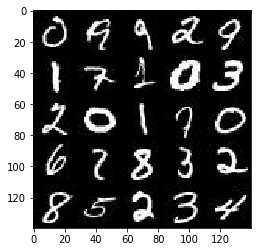

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

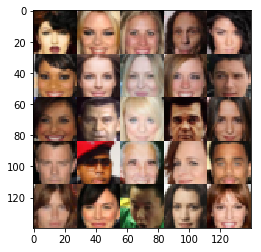

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name ='input_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return  real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer 
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        #flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_opt =  tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    n_batches = data_shape[0] // batch_size
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # According to review, I should first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # Get the losses and print them out at each 25 batches
                
                if batch_counter % 25 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                batch_counter +=1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 0/1875:  Discriminator loss = 4.6195  Generator loss = 0.0207


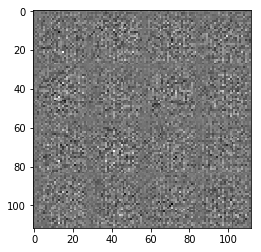

Epoch 1/2 - Batch 25/1875:  Discriminator loss = 1.4538  Generator loss = 0.6738
Epoch 1/2 - Batch 50/1875:  Discriminator loss = 0.5425  Generator loss = 2.5689
Epoch 1/2 - Batch 75/1875:  Discriminator loss = 0.6344  Generator loss = 2.9926
Epoch 1/2 - Batch 100/1875:  Discriminator loss = 0.9442  Generator loss = 1.1872


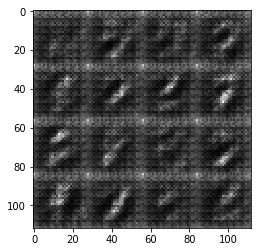

Epoch 1/2 - Batch 125/1875:  Discriminator loss = 0.8079  Generator loss = 2.6174
Epoch 1/2 - Batch 150/1875:  Discriminator loss = 0.7627  Generator loss = 1.5106
Epoch 1/2 - Batch 175/1875:  Discriminator loss = 0.7772  Generator loss = 1.7209
Epoch 1/2 - Batch 200/1875:  Discriminator loss = 2.0115  Generator loss = 0.2773


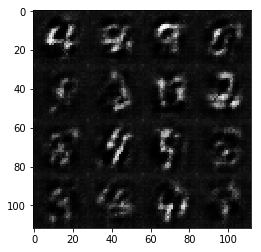

Epoch 1/2 - Batch 225/1875:  Discriminator loss = 0.8496  Generator loss = 1.0914
Epoch 1/2 - Batch 250/1875:  Discriminator loss = 0.8512  Generator loss = 1.1247
Epoch 1/2 - Batch 275/1875:  Discriminator loss = 0.6364  Generator loss = 2.2207
Epoch 1/2 - Batch 300/1875:  Discriminator loss = 0.6384  Generator loss = 2.0542


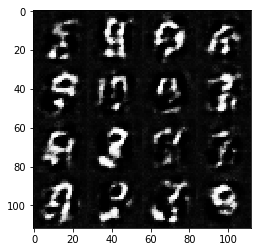

Epoch 1/2 - Batch 325/1875:  Discriminator loss = 0.6140  Generator loss = 1.7241
Epoch 1/2 - Batch 350/1875:  Discriminator loss = 0.5938  Generator loss = 1.7849
Epoch 1/2 - Batch 375/1875:  Discriminator loss = 0.5487  Generator loss = 2.3116
Epoch 1/2 - Batch 400/1875:  Discriminator loss = 0.6116  Generator loss = 1.7382


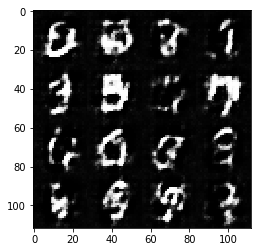

Epoch 1/2 - Batch 425/1875:  Discriminator loss = 0.8227  Generator loss = 1.1642
Epoch 1/2 - Batch 450/1875:  Discriminator loss = 0.5511  Generator loss = 2.3165
Epoch 1/2 - Batch 475/1875:  Discriminator loss = 0.6037  Generator loss = 2.5094
Epoch 1/2 - Batch 500/1875:  Discriminator loss = 0.6432  Generator loss = 2.3011


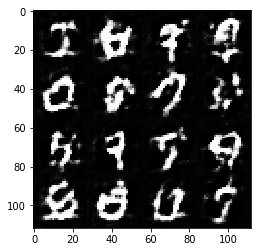

Epoch 1/2 - Batch 525/1875:  Discriminator loss = 0.6871  Generator loss = 1.5540
Epoch 1/2 - Batch 550/1875:  Discriminator loss = 0.9595  Generator loss = 0.9355
Epoch 1/2 - Batch 575/1875:  Discriminator loss = 0.7809  Generator loss = 1.6020
Epoch 1/2 - Batch 600/1875:  Discriminator loss = 0.6505  Generator loss = 1.8068


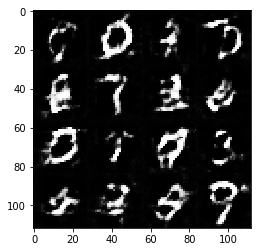

Epoch 1/2 - Batch 625/1875:  Discriminator loss = 0.8761  Generator loss = 1.1263
Epoch 1/2 - Batch 650/1875:  Discriminator loss = 0.5816  Generator loss = 1.8287
Epoch 1/2 - Batch 675/1875:  Discriminator loss = 0.6511  Generator loss = 1.5558
Epoch 1/2 - Batch 700/1875:  Discriminator loss = 1.0911  Generator loss = 0.7556


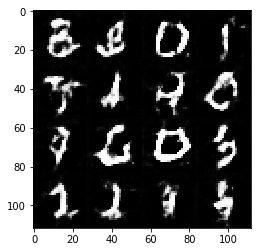

Epoch 1/2 - Batch 725/1875:  Discriminator loss = 6.6998  Generator loss = 8.8884
Epoch 1/2 - Batch 750/1875:  Discriminator loss = 0.7900  Generator loss = 1.2039
Epoch 1/2 - Batch 775/1875:  Discriminator loss = 1.0213  Generator loss = 0.8615
Epoch 1/2 - Batch 800/1875:  Discriminator loss = 1.0918  Generator loss = 0.8340


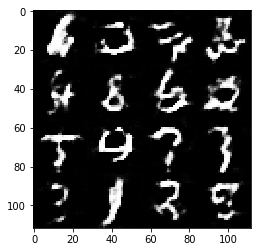

Epoch 1/2 - Batch 825/1875:  Discriminator loss = 0.7954  Generator loss = 2.0606
Epoch 1/2 - Batch 850/1875:  Discriminator loss = 1.1589  Generator loss = 0.8034
Epoch 1/2 - Batch 875/1875:  Discriminator loss = 0.7194  Generator loss = 1.5183
Epoch 1/2 - Batch 900/1875:  Discriminator loss = 0.9948  Generator loss = 3.0782


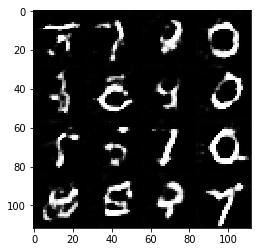

Epoch 1/2 - Batch 925/1875:  Discriminator loss = 1.0723  Generator loss = 0.8147
Epoch 1/2 - Batch 950/1875:  Discriminator loss = 0.8896  Generator loss = 0.9802
Epoch 1/2 - Batch 975/1875:  Discriminator loss = 1.0759  Generator loss = 0.8624
Epoch 1/2 - Batch 1000/1875:  Discriminator loss = 1.1144  Generator loss = 0.7781


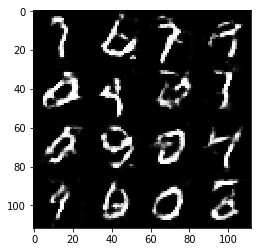

Epoch 1/2 - Batch 1025/1875:  Discriminator loss = 0.7216  Generator loss = 1.3560
Epoch 1/2 - Batch 1050/1875:  Discriminator loss = 0.7870  Generator loss = 1.3789
Epoch 1/2 - Batch 1075/1875:  Discriminator loss = 0.8287  Generator loss = 1.3958
Epoch 1/2 - Batch 1100/1875:  Discriminator loss = 0.7605  Generator loss = 1.4001


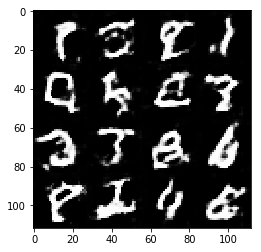

Epoch 1/2 - Batch 1125/1875:  Discriminator loss = 2.5114  Generator loss = 5.1452
Epoch 1/2 - Batch 1150/1875:  Discriminator loss = 1.1213  Generator loss = 0.6987
Epoch 1/2 - Batch 1175/1875:  Discriminator loss = 0.6980  Generator loss = 1.7165
Epoch 1/2 - Batch 1200/1875:  Discriminator loss = 0.6515  Generator loss = 1.5680


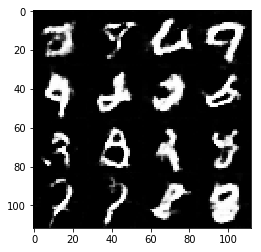

Epoch 1/2 - Batch 1225/1875:  Discriminator loss = 2.3019  Generator loss = 0.2465
Epoch 1/2 - Batch 1250/1875:  Discriminator loss = 0.9644  Generator loss = 0.9421
Epoch 1/2 - Batch 1275/1875:  Discriminator loss = 0.6320  Generator loss = 1.5629
Epoch 1/2 - Batch 1300/1875:  Discriminator loss = 0.7752  Generator loss = 1.2466


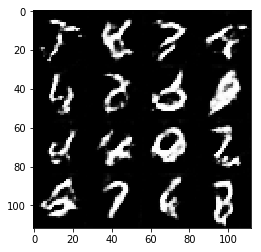

Epoch 1/2 - Batch 1325/1875:  Discriminator loss = 0.7708  Generator loss = 1.3758
Epoch 1/2 - Batch 1350/1875:  Discriminator loss = 1.1495  Generator loss = 0.6607
Epoch 1/2 - Batch 1375/1875:  Discriminator loss = 1.0057  Generator loss = 1.3197
Epoch 1/2 - Batch 1400/1875:  Discriminator loss = 1.4543  Generator loss = 0.4753


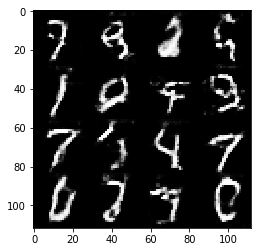

Epoch 1/2 - Batch 1425/1875:  Discriminator loss = 0.6737  Generator loss = 1.5151
Epoch 1/2 - Batch 1450/1875:  Discriminator loss = 1.1510  Generator loss = 0.6957
Epoch 1/2 - Batch 1475/1875:  Discriminator loss = 0.7023  Generator loss = 2.1581
Epoch 1/2 - Batch 1500/1875:  Discriminator loss = 0.6271  Generator loss = 1.6876


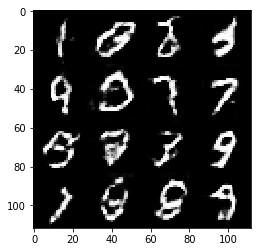

Epoch 1/2 - Batch 1525/1875:  Discriminator loss = 0.6395  Generator loss = 1.6221
Epoch 1/2 - Batch 1550/1875:  Discriminator loss = 0.7715  Generator loss = 1.5498
Epoch 1/2 - Batch 1575/1875:  Discriminator loss = 0.8354  Generator loss = 2.0850
Epoch 1/2 - Batch 1600/1875:  Discriminator loss = 0.6392  Generator loss = 1.5107


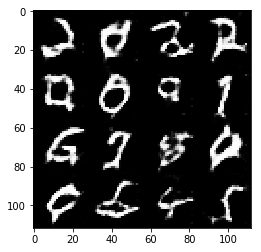

Epoch 1/2 - Batch 1625/1875:  Discriminator loss = 0.7805  Generator loss = 1.6749
Epoch 1/2 - Batch 1650/1875:  Discriminator loss = 0.7808  Generator loss = 1.2638
Epoch 1/2 - Batch 1675/1875:  Discriminator loss = 0.6451  Generator loss = 1.5523
Epoch 1/2 - Batch 1700/1875:  Discriminator loss = 1.1230  Generator loss = 2.7210


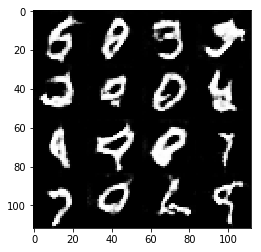

Epoch 1/2 - Batch 1725/1875:  Discriminator loss = 0.6458  Generator loss = 1.5848
Epoch 1/2 - Batch 1750/1875:  Discriminator loss = 1.0557  Generator loss = 0.8523
Epoch 1/2 - Batch 1775/1875:  Discriminator loss = 0.6477  Generator loss = 1.6530
Epoch 1/2 - Batch 1800/1875:  Discriminator loss = 0.7634  Generator loss = 1.4536


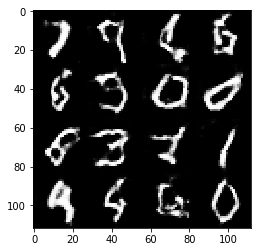

Epoch 1/2 - Batch 1825/1875:  Discriminator loss = 0.7572  Generator loss = 2.0482
Epoch 1/2 - Batch 1850/1875:  Discriminator loss = 0.9570  Generator loss = 0.9627
Epoch 2/2 - Batch 0/1875:  Discriminator loss = 0.7873  Generator loss = 1.2788


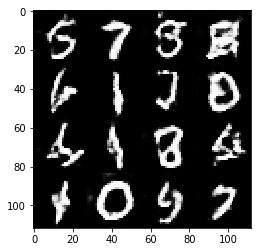

Epoch 2/2 - Batch 25/1875:  Discriminator loss = 0.9193  Generator loss = 1.0449
Epoch 2/2 - Batch 50/1875:  Discriminator loss = 1.5695  Generator loss = 0.5496
Epoch 2/2 - Batch 75/1875:  Discriminator loss = 0.7060  Generator loss = 1.4819
Epoch 2/2 - Batch 100/1875:  Discriminator loss = 0.6928  Generator loss = 1.6629


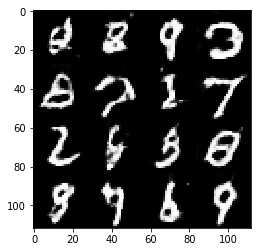

Epoch 2/2 - Batch 125/1875:  Discriminator loss = 0.8918  Generator loss = 1.3113
Epoch 2/2 - Batch 150/1875:  Discriminator loss = 0.7242  Generator loss = 1.6414
Epoch 2/2 - Batch 175/1875:  Discriminator loss = 0.7264  Generator loss = 1.3616
Epoch 2/2 - Batch 200/1875:  Discriminator loss = 1.3373  Generator loss = 0.5415


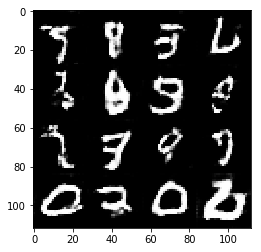

Epoch 2/2 - Batch 225/1875:  Discriminator loss = 0.8274  Generator loss = 1.2144
Epoch 2/2 - Batch 250/1875:  Discriminator loss = 3.1670  Generator loss = 0.1589
Epoch 2/2 - Batch 275/1875:  Discriminator loss = 0.7945  Generator loss = 1.2223
Epoch 2/2 - Batch 300/1875:  Discriminator loss = 0.7945  Generator loss = 1.2372


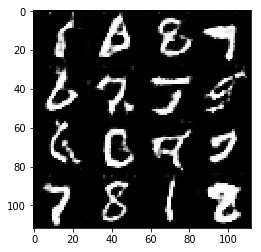

Epoch 2/2 - Batch 325/1875:  Discriminator loss = 0.6515  Generator loss = 1.6199
Epoch 2/2 - Batch 350/1875:  Discriminator loss = 0.5984  Generator loss = 1.9535
Epoch 2/2 - Batch 375/1875:  Discriminator loss = 0.7891  Generator loss = 1.1755
Epoch 2/2 - Batch 400/1875:  Discriminator loss = 0.6018  Generator loss = 1.9111


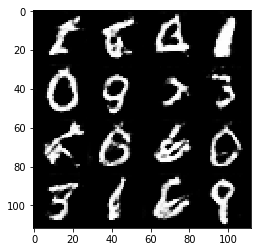

Epoch 2/2 - Batch 425/1875:  Discriminator loss = 0.5860  Generator loss = 1.7431
Epoch 2/2 - Batch 450/1875:  Discriminator loss = 0.6229  Generator loss = 1.8465
Epoch 2/2 - Batch 475/1875:  Discriminator loss = 0.8498  Generator loss = 1.3445
Epoch 2/2 - Batch 500/1875:  Discriminator loss = 1.4658  Generator loss = 0.4971


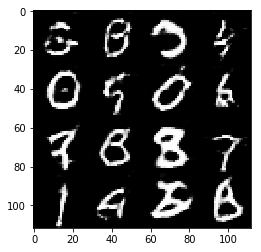

Epoch 2/2 - Batch 525/1875:  Discriminator loss = 1.0142  Generator loss = 0.8853
Epoch 2/2 - Batch 550/1875:  Discriminator loss = 1.0848  Generator loss = 0.8805
Epoch 2/2 - Batch 575/1875:  Discriminator loss = 0.9088  Generator loss = 1.0922
Epoch 2/2 - Batch 600/1875:  Discriminator loss = 0.7549  Generator loss = 1.3126


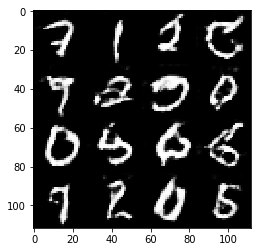

Epoch 2/2 - Batch 625/1875:  Discriminator loss = 0.9861  Generator loss = 0.8963
Epoch 2/2 - Batch 650/1875:  Discriminator loss = 1.0931  Generator loss = 0.9035
Epoch 2/2 - Batch 675/1875:  Discriminator loss = 0.7845  Generator loss = 2.9346
Epoch 2/2 - Batch 700/1875:  Discriminator loss = 0.8360  Generator loss = 1.1873


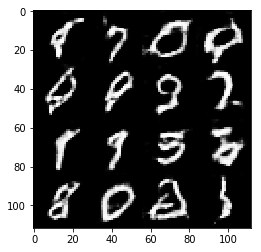

Epoch 2/2 - Batch 725/1875:  Discriminator loss = 0.6209  Generator loss = 1.9157
Epoch 2/2 - Batch 750/1875:  Discriminator loss = 0.6727  Generator loss = 1.8208
Epoch 2/2 - Batch 775/1875:  Discriminator loss = 1.4321  Generator loss = 0.5328
Epoch 2/2 - Batch 800/1875:  Discriminator loss = 0.5551  Generator loss = 2.0205


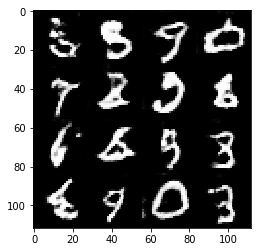

Epoch 2/2 - Batch 825/1875:  Discriminator loss = 0.7118  Generator loss = 1.3795
Epoch 2/2 - Batch 850/1875:  Discriminator loss = 0.6452  Generator loss = 1.7266
Epoch 2/2 - Batch 875/1875:  Discriminator loss = 0.7453  Generator loss = 1.5648
Epoch 2/2 - Batch 900/1875:  Discriminator loss = 0.6988  Generator loss = 1.3544


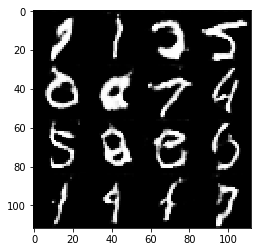

Epoch 2/2 - Batch 925/1875:  Discriminator loss = 0.7209  Generator loss = 1.5773
Epoch 2/2 - Batch 950/1875:  Discriminator loss = 0.7179  Generator loss = 1.4146
Epoch 2/2 - Batch 975/1875:  Discriminator loss = 0.5321  Generator loss = 2.3583
Epoch 2/2 - Batch 1000/1875:  Discriminator loss = 0.6245  Generator loss = 2.2561


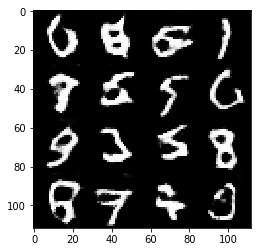

Epoch 2/2 - Batch 1025/1875:  Discriminator loss = 0.7478  Generator loss = 1.4023
Epoch 2/2 - Batch 1050/1875:  Discriminator loss = 0.6512  Generator loss = 1.6745
Epoch 2/2 - Batch 1075/1875:  Discriminator loss = 0.9230  Generator loss = 0.9963
Epoch 2/2 - Batch 1100/1875:  Discriminator loss = 0.9510  Generator loss = 0.9609


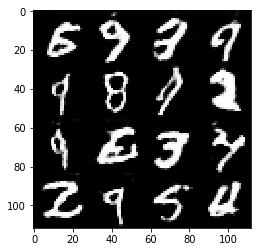

Epoch 2/2 - Batch 1125/1875:  Discriminator loss = 0.8622  Generator loss = 3.3210
Epoch 2/2 - Batch 1150/1875:  Discriminator loss = 1.2206  Generator loss = 0.6989
Epoch 2/2 - Batch 1175/1875:  Discriminator loss = 0.6153  Generator loss = 1.9597
Epoch 2/2 - Batch 1200/1875:  Discriminator loss = 0.5308  Generator loss = 2.0850


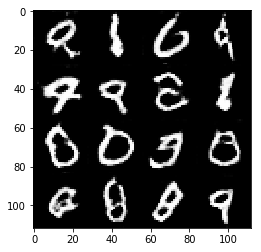

Epoch 2/2 - Batch 1225/1875:  Discriminator loss = 0.5449  Generator loss = 2.2856
Epoch 2/2 - Batch 1250/1875:  Discriminator loss = 0.7265  Generator loss = 1.3648
Epoch 2/2 - Batch 1275/1875:  Discriminator loss = 0.5337  Generator loss = 2.7252
Epoch 2/2 - Batch 1300/1875:  Discriminator loss = 0.9032  Generator loss = 1.1114


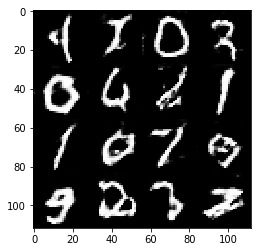

Epoch 2/2 - Batch 1325/1875:  Discriminator loss = 0.6965  Generator loss = 1.4838
Epoch 2/2 - Batch 1350/1875:  Discriminator loss = 0.7609  Generator loss = 1.3155
Epoch 2/2 - Batch 1375/1875:  Discriminator loss = 0.6258  Generator loss = 2.1457
Epoch 2/2 - Batch 1400/1875:  Discriminator loss = 0.5047  Generator loss = 2.3778


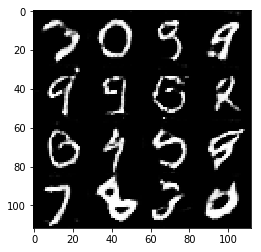

Epoch 2/2 - Batch 1425/1875:  Discriminator loss = 0.6134  Generator loss = 1.8369
Epoch 2/2 - Batch 1450/1875:  Discriminator loss = 0.7639  Generator loss = 1.2015
Epoch 2/2 - Batch 1475/1875:  Discriminator loss = 0.5395  Generator loss = 2.2954
Epoch 2/2 - Batch 1500/1875:  Discriminator loss = 0.5292  Generator loss = 2.4139


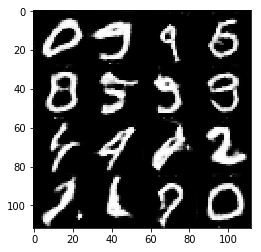

Epoch 2/2 - Batch 1525/1875:  Discriminator loss = 0.7298  Generator loss = 2.3373
Epoch 2/2 - Batch 1550/1875:  Discriminator loss = 0.6767  Generator loss = 1.7545
Epoch 2/2 - Batch 1575/1875:  Discriminator loss = 0.5861  Generator loss = 1.9450
Epoch 2/2 - Batch 1600/1875:  Discriminator loss = 0.5355  Generator loss = 2.2934


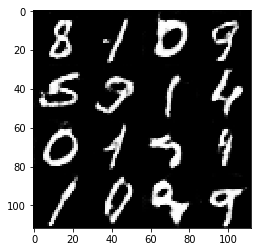

Epoch 2/2 - Batch 1625/1875:  Discriminator loss = 0.6173  Generator loss = 1.7262
Epoch 2/2 - Batch 1650/1875:  Discriminator loss = 0.7583  Generator loss = 1.5318
Epoch 2/2 - Batch 1675/1875:  Discriminator loss = 0.4720  Generator loss = 2.8746
Epoch 2/2 - Batch 1700/1875:  Discriminator loss = 0.4945  Generator loss = 2.6116


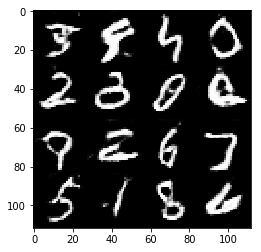

Epoch 2/2 - Batch 1725/1875:  Discriminator loss = 0.6134  Generator loss = 1.8470
Epoch 2/2 - Batch 1750/1875:  Discriminator loss = 0.5724  Generator loss = 1.9002
Epoch 2/2 - Batch 1775/1875:  Discriminator loss = 0.6899  Generator loss = 1.5124
Epoch 2/2 - Batch 1800/1875:  Discriminator loss = 1.2056  Generator loss = 3.9647


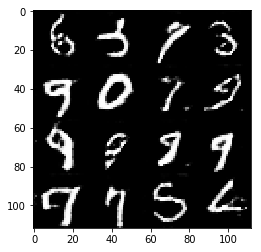

Epoch 2/2 - Batch 1825/1875:  Discriminator loss = 0.5507  Generator loss = 1.9896
Epoch 2/2 - Batch 1850/1875:  Discriminator loss = 0.7550  Generator loss = 1.2470


In [22]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 0/3165:  Discriminator loss = 2.3915  Generator loss = 0.1656


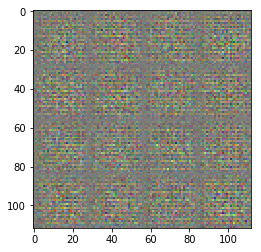

Epoch 1/1 - Batch 25/3165:  Discriminator loss = 0.6367  Generator loss = 1.7419
Epoch 1/1 - Batch 50/3165:  Discriminator loss = 0.4386  Generator loss = 3.0374
Epoch 1/1 - Batch 75/3165:  Discriminator loss = 0.3816  Generator loss = 3.6939
Epoch 1/1 - Batch 100/3165:  Discriminator loss = 0.5421  Generator loss = 2.7256


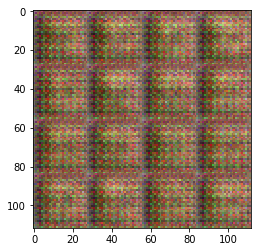

Epoch 1/1 - Batch 125/3165:  Discriminator loss = 0.4607  Generator loss = 3.1238
Epoch 1/1 - Batch 150/3165:  Discriminator loss = 0.5793  Generator loss = 1.9363
Epoch 1/1 - Batch 175/3165:  Discriminator loss = 0.8388  Generator loss = 1.1333
Epoch 1/1 - Batch 200/3165:  Discriminator loss = 0.5030  Generator loss = 2.5984


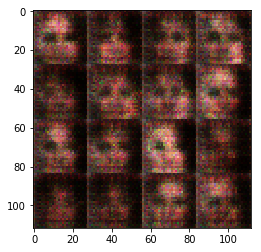

Epoch 1/1 - Batch 225/3165:  Discriminator loss = 0.4918  Generator loss = 2.6501
Epoch 1/1 - Batch 250/3165:  Discriminator loss = 0.5939  Generator loss = 2.2773
Epoch 1/1 - Batch 275/3165:  Discriminator loss = 0.5682  Generator loss = 2.2317
Epoch 1/1 - Batch 300/3165:  Discriminator loss = 0.5708  Generator loss = 3.1809


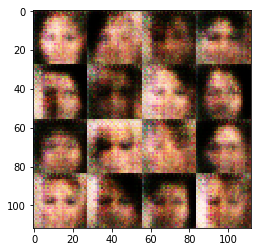

Epoch 1/1 - Batch 325/3165:  Discriminator loss = 0.5834  Generator loss = 2.0150
Epoch 1/1 - Batch 350/3165:  Discriminator loss = 0.7408  Generator loss = 1.5656
Epoch 1/1 - Batch 375/3165:  Discriminator loss = 0.7290  Generator loss = 2.9446
Epoch 1/1 - Batch 400/3165:  Discriminator loss = 1.0797  Generator loss = 0.7863


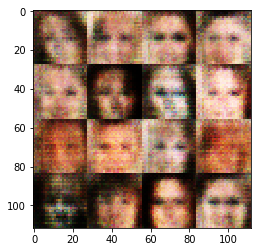

Epoch 1/1 - Batch 425/3165:  Discriminator loss = 1.0048  Generator loss = 0.9284
Epoch 1/1 - Batch 450/3165:  Discriminator loss = 0.7374  Generator loss = 2.2216
Epoch 1/1 - Batch 475/3165:  Discriminator loss = 0.6401  Generator loss = 2.0040
Epoch 1/1 - Batch 500/3165:  Discriminator loss = 0.8173  Generator loss = 1.4127


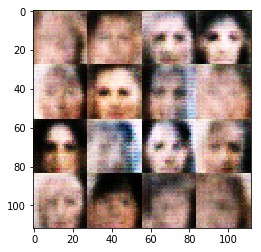

Epoch 1/1 - Batch 525/3165:  Discriminator loss = 0.8491  Generator loss = 1.2074
Epoch 1/1 - Batch 550/3165:  Discriminator loss = 0.5780  Generator loss = 2.7818
Epoch 1/1 - Batch 575/3165:  Discriminator loss = 0.7732  Generator loss = 1.7380
Epoch 1/1 - Batch 600/3165:  Discriminator loss = 0.8014  Generator loss = 1.4561


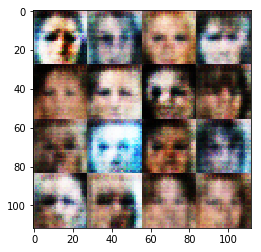

Epoch 1/1 - Batch 625/3165:  Discriminator loss = 0.9713  Generator loss = 3.0004
Epoch 1/1 - Batch 650/3165:  Discriminator loss = 1.1811  Generator loss = 2.8068
Epoch 1/1 - Batch 675/3165:  Discriminator loss = 0.8489  Generator loss = 2.2560
Epoch 1/1 - Batch 700/3165:  Discriminator loss = 0.7198  Generator loss = 1.5223


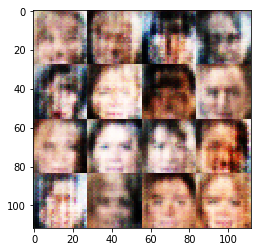

Epoch 1/1 - Batch 725/3165:  Discriminator loss = 0.7577  Generator loss = 1.3896
Epoch 1/1 - Batch 750/3165:  Discriminator loss = 0.7906  Generator loss = 1.2802
Epoch 1/1 - Batch 775/3165:  Discriminator loss = 1.0009  Generator loss = 2.3679
Epoch 1/1 - Batch 800/3165:  Discriminator loss = 1.0413  Generator loss = 2.5739


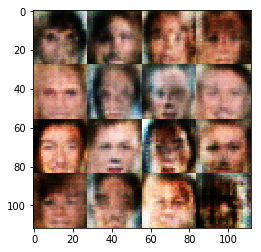

Epoch 1/1 - Batch 825/3165:  Discriminator loss = 0.7652  Generator loss = 1.7042
Epoch 1/1 - Batch 850/3165:  Discriminator loss = 1.4768  Generator loss = 0.4943
Epoch 1/1 - Batch 875/3165:  Discriminator loss = 0.9021  Generator loss = 2.8567
Epoch 1/1 - Batch 900/3165:  Discriminator loss = 0.7531  Generator loss = 2.0009


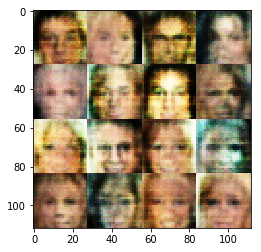

Epoch 1/1 - Batch 925/3165:  Discriminator loss = 0.7980  Generator loss = 1.6086
Epoch 1/1 - Batch 950/3165:  Discriminator loss = 0.9685  Generator loss = 2.2978
Epoch 1/1 - Batch 975/3165:  Discriminator loss = 1.0783  Generator loss = 0.8922
Epoch 1/1 - Batch 1000/3165:  Discriminator loss = 0.8018  Generator loss = 1.3839


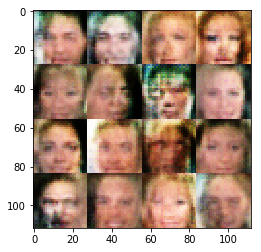

Epoch 1/1 - Batch 1025/3165:  Discriminator loss = 0.7921  Generator loss = 1.4283
Epoch 1/1 - Batch 1050/3165:  Discriminator loss = 0.9685  Generator loss = 1.0408
Epoch 1/1 - Batch 1075/3165:  Discriminator loss = 0.8178  Generator loss = 1.3771
Epoch 1/1 - Batch 1100/3165:  Discriminator loss = 1.2645  Generator loss = 0.6279


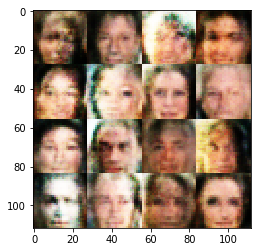

Epoch 1/1 - Batch 1125/3165:  Discriminator loss = 0.8833  Generator loss = 1.0760
Epoch 1/1 - Batch 1150/3165:  Discriminator loss = 0.7654  Generator loss = 1.4120
Epoch 1/1 - Batch 1175/3165:  Discriminator loss = 0.8341  Generator loss = 1.3486
Epoch 1/1 - Batch 1200/3165:  Discriminator loss = 0.8498  Generator loss = 1.1972


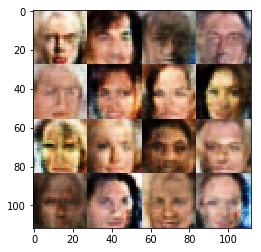

Epoch 1/1 - Batch 1225/3165:  Discriminator loss = 0.8896  Generator loss = 1.3060
Epoch 1/1 - Batch 1250/3165:  Discriminator loss = 0.9439  Generator loss = 0.9055
Epoch 1/1 - Batch 1275/3165:  Discriminator loss = 0.9014  Generator loss = 1.0650
Epoch 1/1 - Batch 1300/3165:  Discriminator loss = 0.8657  Generator loss = 2.0262


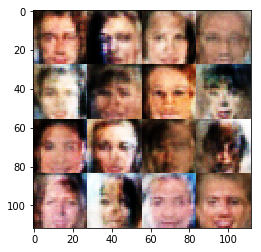

Epoch 1/1 - Batch 1325/3165:  Discriminator loss = 0.8870  Generator loss = 1.1971
Epoch 1/1 - Batch 1350/3165:  Discriminator loss = 1.6394  Generator loss = 0.4396
Epoch 1/1 - Batch 1375/3165:  Discriminator loss = 0.9718  Generator loss = 0.9553
Epoch 1/1 - Batch 1400/3165:  Discriminator loss = 1.0815  Generator loss = 0.8016


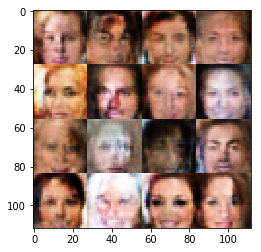

Epoch 1/1 - Batch 1425/3165:  Discriminator loss = 0.7394  Generator loss = 1.6378
Epoch 1/1 - Batch 1450/3165:  Discriminator loss = 0.8993  Generator loss = 1.2302
Epoch 1/1 - Batch 1475/3165:  Discriminator loss = 0.8820  Generator loss = 1.0990
Epoch 1/1 - Batch 1500/3165:  Discriminator loss = 0.8669  Generator loss = 1.4098


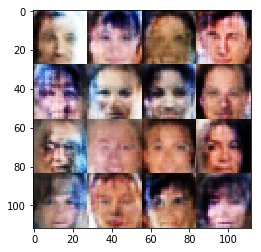

Epoch 1/1 - Batch 1525/3165:  Discriminator loss = 0.8723  Generator loss = 1.1534
Epoch 1/1 - Batch 1550/3165:  Discriminator loss = 1.0573  Generator loss = 0.8437
Epoch 1/1 - Batch 1575/3165:  Discriminator loss = 0.9649  Generator loss = 1.1560
Epoch 1/1 - Batch 1600/3165:  Discriminator loss = 1.0113  Generator loss = 0.8467


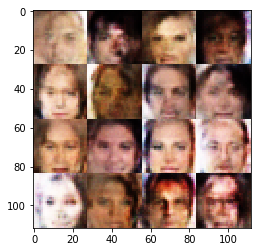

Epoch 1/1 - Batch 1625/3165:  Discriminator loss = 0.7130  Generator loss = 1.8348
Epoch 1/1 - Batch 1650/3165:  Discriminator loss = 0.8184  Generator loss = 1.3685
Epoch 1/1 - Batch 1675/3165:  Discriminator loss = 0.8210  Generator loss = 1.9093
Epoch 1/1 - Batch 1700/3165:  Discriminator loss = 1.0196  Generator loss = 0.8142


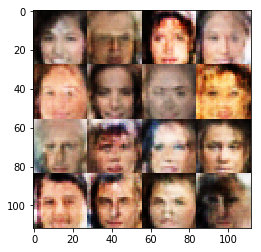

Epoch 1/1 - Batch 1725/3165:  Discriminator loss = 0.5972  Generator loss = 2.6239
Epoch 1/1 - Batch 1750/3165:  Discriminator loss = 0.8679  Generator loss = 1.3844
Epoch 1/1 - Batch 1775/3165:  Discriminator loss = 0.9830  Generator loss = 0.9164
Epoch 1/1 - Batch 1800/3165:  Discriminator loss = 0.8434  Generator loss = 1.2110


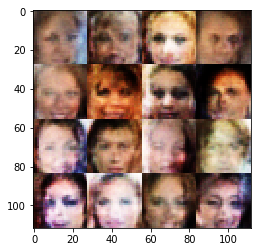

Epoch 1/1 - Batch 1825/3165:  Discriminator loss = 0.6644  Generator loss = 2.3464
Epoch 1/1 - Batch 1850/3165:  Discriminator loss = 0.8724  Generator loss = 1.6298
Epoch 1/1 - Batch 1875/3165:  Discriminator loss = 0.7480  Generator loss = 1.4333
Epoch 1/1 - Batch 1900/3165:  Discriminator loss = 0.8592  Generator loss = 1.0813


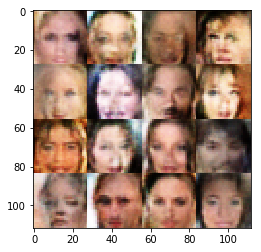

Epoch 1/1 - Batch 1925/3165:  Discriminator loss = 0.7835  Generator loss = 1.4342
Epoch 1/1 - Batch 1950/3165:  Discriminator loss = 0.8730  Generator loss = 1.7479
Epoch 1/1 - Batch 1975/3165:  Discriminator loss = 0.7285  Generator loss = 1.5607
Epoch 1/1 - Batch 2000/3165:  Discriminator loss = 0.8926  Generator loss = 1.1028


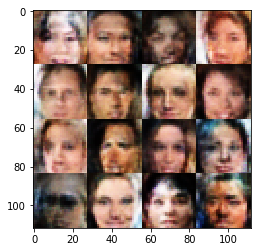

Epoch 1/1 - Batch 2025/3165:  Discriminator loss = 0.9677  Generator loss = 0.9683
Epoch 1/1 - Batch 2050/3165:  Discriminator loss = 1.0081  Generator loss = 0.8337
Epoch 1/1 - Batch 2075/3165:  Discriminator loss = 0.7169  Generator loss = 1.9446
Epoch 1/1 - Batch 2100/3165:  Discriminator loss = 0.6758  Generator loss = 1.8729


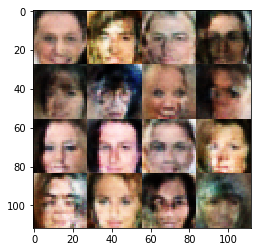

Epoch 1/1 - Batch 2125/3165:  Discriminator loss = 0.9241  Generator loss = 0.9671
Epoch 1/1 - Batch 2150/3165:  Discriminator loss = 0.9077  Generator loss = 1.3292
Epoch 1/1 - Batch 2175/3165:  Discriminator loss = 0.8823  Generator loss = 1.0743
Epoch 1/1 - Batch 2200/3165:  Discriminator loss = 0.7341  Generator loss = 1.7705


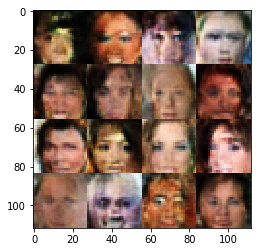

Epoch 1/1 - Batch 2225/3165:  Discriminator loss = 0.7813  Generator loss = 1.4109
Epoch 1/1 - Batch 2250/3165:  Discriminator loss = 0.9910  Generator loss = 2.7173
Epoch 1/1 - Batch 2275/3165:  Discriminator loss = 0.8003  Generator loss = 1.2980
Epoch 1/1 - Batch 2300/3165:  Discriminator loss = 0.8321  Generator loss = 1.2700


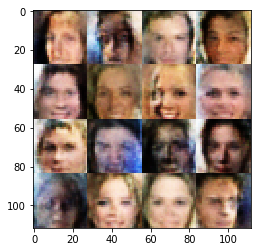

Epoch 1/1 - Batch 2325/3165:  Discriminator loss = 0.9140  Generator loss = 0.9937
Epoch 1/1 - Batch 2350/3165:  Discriminator loss = 0.7861  Generator loss = 1.3815
Epoch 1/1 - Batch 2375/3165:  Discriminator loss = 0.8512  Generator loss = 1.8237
Epoch 1/1 - Batch 2400/3165:  Discriminator loss = 0.9249  Generator loss = 1.0081


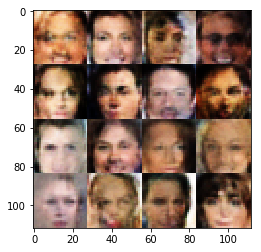

Epoch 1/1 - Batch 2425/3165:  Discriminator loss = 1.0730  Generator loss = 1.0341
Epoch 1/1 - Batch 2450/3165:  Discriminator loss = 0.9168  Generator loss = 1.3008
Epoch 1/1 - Batch 2475/3165:  Discriminator loss = 0.8655  Generator loss = 1.1895
Epoch 1/1 - Batch 2500/3165:  Discriminator loss = 1.2680  Generator loss = 0.5880


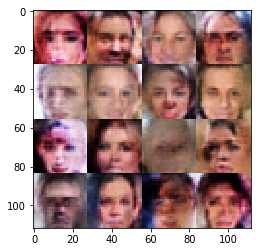

Epoch 1/1 - Batch 2525/3165:  Discriminator loss = 0.8659  Generator loss = 1.2049
Epoch 1/1 - Batch 2550/3165:  Discriminator loss = 0.9676  Generator loss = 1.0265
Epoch 1/1 - Batch 2575/3165:  Discriminator loss = 0.9109  Generator loss = 0.9875
Epoch 1/1 - Batch 2600/3165:  Discriminator loss = 0.7211  Generator loss = 1.4620


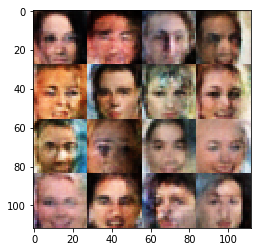

Epoch 1/1 - Batch 2625/3165:  Discriminator loss = 0.6273  Generator loss = 2.0566
Epoch 1/1 - Batch 2650/3165:  Discriminator loss = 0.6783  Generator loss = 1.6808
Epoch 1/1 - Batch 2675/3165:  Discriminator loss = 0.9456  Generator loss = 0.9253
Epoch 1/1 - Batch 2700/3165:  Discriminator loss = 0.9983  Generator loss = 2.1717


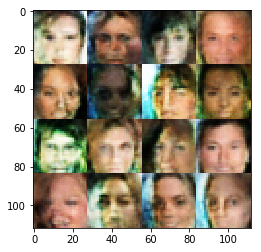

Epoch 1/1 - Batch 2725/3165:  Discriminator loss = 0.7115  Generator loss = 1.4485
Epoch 1/1 - Batch 2750/3165:  Discriminator loss = 0.8918  Generator loss = 1.0647
Epoch 1/1 - Batch 2775/3165:  Discriminator loss = 0.7192  Generator loss = 1.8737
Epoch 1/1 - Batch 2800/3165:  Discriminator loss = 0.8244  Generator loss = 1.1295


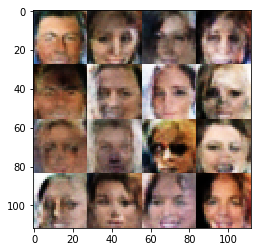

Epoch 1/1 - Batch 2825/3165:  Discriminator loss = 0.7326  Generator loss = 1.6344
Epoch 1/1 - Batch 2850/3165:  Discriminator loss = 0.9703  Generator loss = 0.8987
Epoch 1/1 - Batch 2875/3165:  Discriminator loss = 0.6727  Generator loss = 1.6881
Epoch 1/1 - Batch 2900/3165:  Discriminator loss = 1.0420  Generator loss = 2.1473


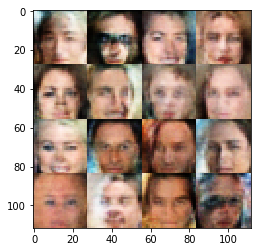

Epoch 1/1 - Batch 2925/3165:  Discriminator loss = 0.5166  Generator loss = 2.2493
Epoch 1/1 - Batch 2950/3165:  Discriminator loss = 0.8208  Generator loss = 1.3361
Epoch 1/1 - Batch 2975/3165:  Discriminator loss = 0.8691  Generator loss = 1.3122
Epoch 1/1 - Batch 3000/3165:  Discriminator loss = 0.7575  Generator loss = 1.3596


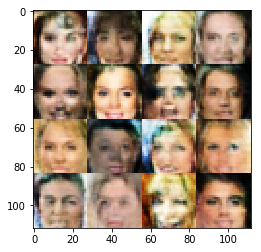

Epoch 1/1 - Batch 3025/3165:  Discriminator loss = 0.8878  Generator loss = 0.9846
Epoch 1/1 - Batch 3050/3165:  Discriminator loss = 0.6557  Generator loss = 1.9268
Epoch 1/1 - Batch 3075/3165:  Discriminator loss = 0.7665  Generator loss = 1.2603
Epoch 1/1 - Batch 3100/3165:  Discriminator loss = 0.9184  Generator loss = 1.3596


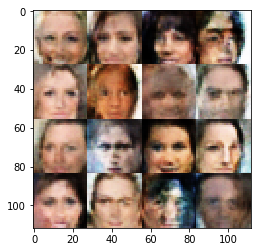

Epoch 1/1 - Batch 3125/3165:  Discriminator loss = 0.7240  Generator loss = 1.4312
Epoch 1/1 - Batch 3150/3165:  Discriminator loss = 0.8478  Generator loss = 1.0919


In [24]:
batch_size = 64
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.